# Traffic Control Scenario Comparison

Comprehensive comparison of four traffic control strategies:
- **Baseline**: Original network with fixed timing
- **Actuated**: Actuated traffic control
- **Max Pressure**: Max Pressure traffic control
- **RL**: Reinforcement Learning traffic control

This analysis compares:
- Average waiting time, time loss, and trip duration
- Traffic flow efficiency and speed
- Performance improvements over baseline
- Multi-dimensional rankings

**Output**: Results saved to `Scenario comparison results/`

In [1]:
# ==========================================
# 1. IMPORTS AND CONFIGURATION
# ==========================================
import os
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from math import pi

# Set up plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# Define paths
BASE_DIR = os.getcwd()
OUTPUT_DIR = os.path.join(BASE_DIR, 'Scenario comparison results')

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Define scenario paths
SCENARIOS = {
    'Baseline': os.path.join(BASE_DIR, 'Original network'),
    'Actuated': os.path.join(BASE_DIR, 'Network with actuated control'),
    'Max Pressure': os.path.join(BASE_DIR, 'Network with max pressure control'),
    'RL': os.path.join(BASE_DIR, 'Network with RL control')
}

print("="*80)
print("SCENARIO COMPARISON CONFIGURATION")
print("="*80)
print(f"Output directory: {OUTPUT_DIR}")
print(f"\nScenario paths:")
for name, path in SCENARIOS.items():
    results_exists = os.path.exists(os.path.join(path, 'results'))
    print(f"  {name:15s}: {results_exists} - {path}")
print("="*80)

SCENARIO COMPARISON CONFIGURATION
Output directory: c:\Users\antoi\OneDrive\Documents\Documents\Devoirs\Études sup\ENTPE 3A\Majeure transports\Mobility Control and Management\Project\Livrable 2\MOCOM_project_2\Scenario comparison results

Scenario paths:
  Baseline       : True - c:\Users\antoi\OneDrive\Documents\Documents\Devoirs\Études sup\ENTPE 3A\Majeure transports\Mobility Control and Management\Project\Livrable 2\MOCOM_project_2\Original network
  Actuated       : True - c:\Users\antoi\OneDrive\Documents\Documents\Devoirs\Études sup\ENTPE 3A\Majeure transports\Mobility Control and Management\Project\Livrable 2\MOCOM_project_2\Network with actuated control
  Max Pressure   : True - c:\Users\antoi\OneDrive\Documents\Documents\Devoirs\Études sup\ENTPE 3A\Majeure transports\Mobility Control and Management\Project\Livrable 2\MOCOM_project_2\Network with max pressure control
  RL             : True - c:\Users\antoi\OneDrive\Documents\Documents\Devoirs\Études sup\ENTPE 3A\Majeure transp

In [4]:
# ==========================================
# 2. DATA LOADING AND PARSING
# ==========================================
import shutil

def ensure_tripinfo_exists(scenario_path, scenario_name):
    """
    Ensure tripinfo.xml exists in results folder.
    If not, try to find it in parent directory or use alternative names.
    Returns the path to tripinfo.xml if found/created, None otherwise.
    """
    results_dir = os.path.join(scenario_path, 'results')
    tripinfo_path = os.path.join(results_dir, 'tripinfo.xml')
    
    # Create results directory if it doesn't exist
    os.makedirs(results_dir, exist_ok=True)
    
    # For RL scenario, prefer tripinfo_eval_ep999.xml (evaluation results)
    if scenario_name == 'RL':
        eval_tripinfo = os.path.join(results_dir, 'tripinfo_eval_ep999.xml')
        if os.path.exists(eval_tripinfo):
            print(f"  → Using {os.path.basename(eval_tripinfo)} for RL scenario")
            # If corrupted tripinfo.xml exists, remove it first
            if os.path.exists(tripinfo_path):
                try:
                    os.remove(tripinfo_path)
                    print(f"  → Removed corrupted tripinfo.xml")
                except:
                    pass
            shutil.copy(eval_tripinfo, tripinfo_path)
            return tripinfo_path
    
    # Check if tripinfo.xml already exists in results/
    if os.path.exists(tripinfo_path):
        # Verify it's valid XML
        try:
            tree = ET.parse(tripinfo_path)
            return tripinfo_path
        except ET.ParseError:
            print(f"  ⚠ Existing tripinfo.xml is corrupted, looking for alternatives...")
            # Try to remove corrupted file
            try:
                os.remove(tripinfo_path)
            except:
                pass
    
    # Check if tripinfo.xml exists in parent directory (scenario root)
    parent_tripinfo = os.path.join(scenario_path, 'tripinfo.xml')
    if os.path.exists(parent_tripinfo):
        print(f"  → Copying tripinfo.xml from scenario root to results/")
        shutil.copy(parent_tripinfo, tripinfo_path)
        return tripinfo_path
    
    return None

def parse_tripinfo(tripinfo_path):
    """
    Parse tripinfo XML file and extract KPIs.
    Returns: (metrics_dict, dataframe) or None if file doesn't exist or is corrupted
    """
    if not os.path.exists(tripinfo_path):
        return None
    
    try:
        tree = ET.parse(tripinfo_path)
        root = tree.getroot()
        
        trips = []
        for tripinfo in root.findall('tripinfo'):
            trip = {
                'id': tripinfo.get('id'),
                'duration': float(tripinfo.get('duration')),
                'waitingTime': float(tripinfo.get('waitingTime')),
                'timeLoss': float(tripinfo.get('timeLoss')),
                'routeLength': float(tripinfo.get('routeLength')),
                'departSpeed': float(tripinfo.get('departSpeed')),
                'arrivalSpeed': float(tripinfo.get('arrivalSpeed')),
            }
            trips.append(trip)
        
        if not trips:
            return None
        
        df = pd.DataFrame(trips)
        
        metrics = {
            'num_vehicles': len(df),
            'avg_duration': df['duration'].mean(),
            'avg_waiting_time': df['waitingTime'].mean(),
            'total_waiting_time': df['waitingTime'].sum(),
            'avg_time_loss': df['timeLoss'].mean(),
            'total_time_loss': df['timeLoss'].sum(),
            'avg_route_length': df['routeLength'].mean(),
            'std_waiting_time': df['waitingTime'].std(),
            'max_waiting_time': df['waitingTime'].max(),
            'min_waiting_time': df['waitingTime'].min(),
            'avg_arrival_speed': df['arrivalSpeed'].mean(),
        }
        
        return metrics, df
    
    except ET.ParseError as e:
        print(f"  ⚠ XML Parse Error: {e}")
        return None
    except Exception as e:
        print(f"  ⚠ Error: {e}")
        return None

# Parse all scenarios
print("\nLoading scenario data...")
results_data = {}
for scenario_name, scenario_path in SCENARIOS.items():
    print(f"\n{scenario_name}:")
    
    # Ensure tripinfo.xml exists in results folder
    tripinfo_path = ensure_tripinfo_exists(scenario_path, scenario_name)
    
    if tripinfo_path is None:
        print(f"  ✗ tripinfo.xml not found")
        continue
    
    # Parse the file
    result = parse_tripinfo(tripinfo_path)
    if result:
        metrics, df = result
        results_data[scenario_name] = {'metrics': metrics, 'df': df}
        print(f"  ✓ Successfully processed {metrics['num_vehicles']:,} vehicles")
    else:
        print(f"  ✗ Could not parse tripinfo.xml")

print(f"\n{'='*80}")
print(f"✓ Data loading complete! {len(results_data)}/{len(SCENARIOS)} scenarios loaded.")
print(f"{'='*80}")


Loading scenario data...

Baseline:
  ✓ Successfully processed 7,315 vehicles

Actuated:
  ✓ Successfully processed 5,795 vehicles

Max Pressure:
  ✓ Successfully processed 7,137 vehicles

RL:
  → Using tripinfo_eval_ep999.xml for RL scenario
  → Removed corrupted tripinfo.xml
  ✓ Successfully processed 5,907 vehicles

✓ Data loading complete! 4/4 scenarios loaded.


## 3. Summary Statistics

In [5]:
# Create summary DataFrame
summary_data = []
for scenario_name, result in results_data.items():
    metrics = result['metrics']
    summary_data.append({
        'Scenario': scenario_name,
        'Num Vehicles': metrics['num_vehicles'],
        'Avg Waiting Time (s)': metrics['avg_waiting_time'],
        'Total Waiting Time (s)': metrics['total_waiting_time'],
        'Avg Time Loss (s)': metrics['avg_time_loss'],
        'Avg Duration (s)': metrics['avg_duration'],
        'Avg Arrival Speed (m/s)': metrics['avg_arrival_speed'],
        'Max Waiting Time (s)': metrics['max_waiting_time'],
    })

summary_df = pd.DataFrame(summary_data).set_index('Scenario')

# Save summary table to CSV
summary_csv = os.path.join(OUTPUT_DIR, 'summary_statistics.csv')
summary_df.to_csv(summary_csv)

print("\n" + "="*100)
print("SUMMARY STATISTICS - All Scenarios")
print("="*100)
print(summary_df.round(2).to_string())
print("="*100)
print(f"\n✓ Summary saved to: {summary_csv}")


SUMMARY STATISTICS - All Scenarios
              Num Vehicles  Avg Waiting Time (s)  Total Waiting Time (s)  Avg Time Loss (s)  Avg Duration (s)  Avg Arrival Speed (m/s)  Max Waiting Time (s)
Scenario                                                                                                                                                    
Baseline              7315                209.84               1534954.0             273.08            387.10                     9.14                2537.0
Actuated              5795                253.30               1467889.0             315.74            431.71                     9.05                2818.0
Max Pressure          7137                186.37               1330093.0             250.65            365.27                     9.09                2465.0
RL                    5907                248.45               1467589.0             308.41            425.02                     9.08                2449.0

✓ Summary saved to: c

## 4. Key Performance Indicators - Visual Comparison

✓ KPI comparison plot saved to: c:\Users\antoi\OneDrive\Documents\Documents\Devoirs\Études sup\ENTPE 3A\Majeure transports\Mobility Control and Management\Project\Livrable 2\MOCOM_project_2\Scenario comparison results\kpi_comparison.png


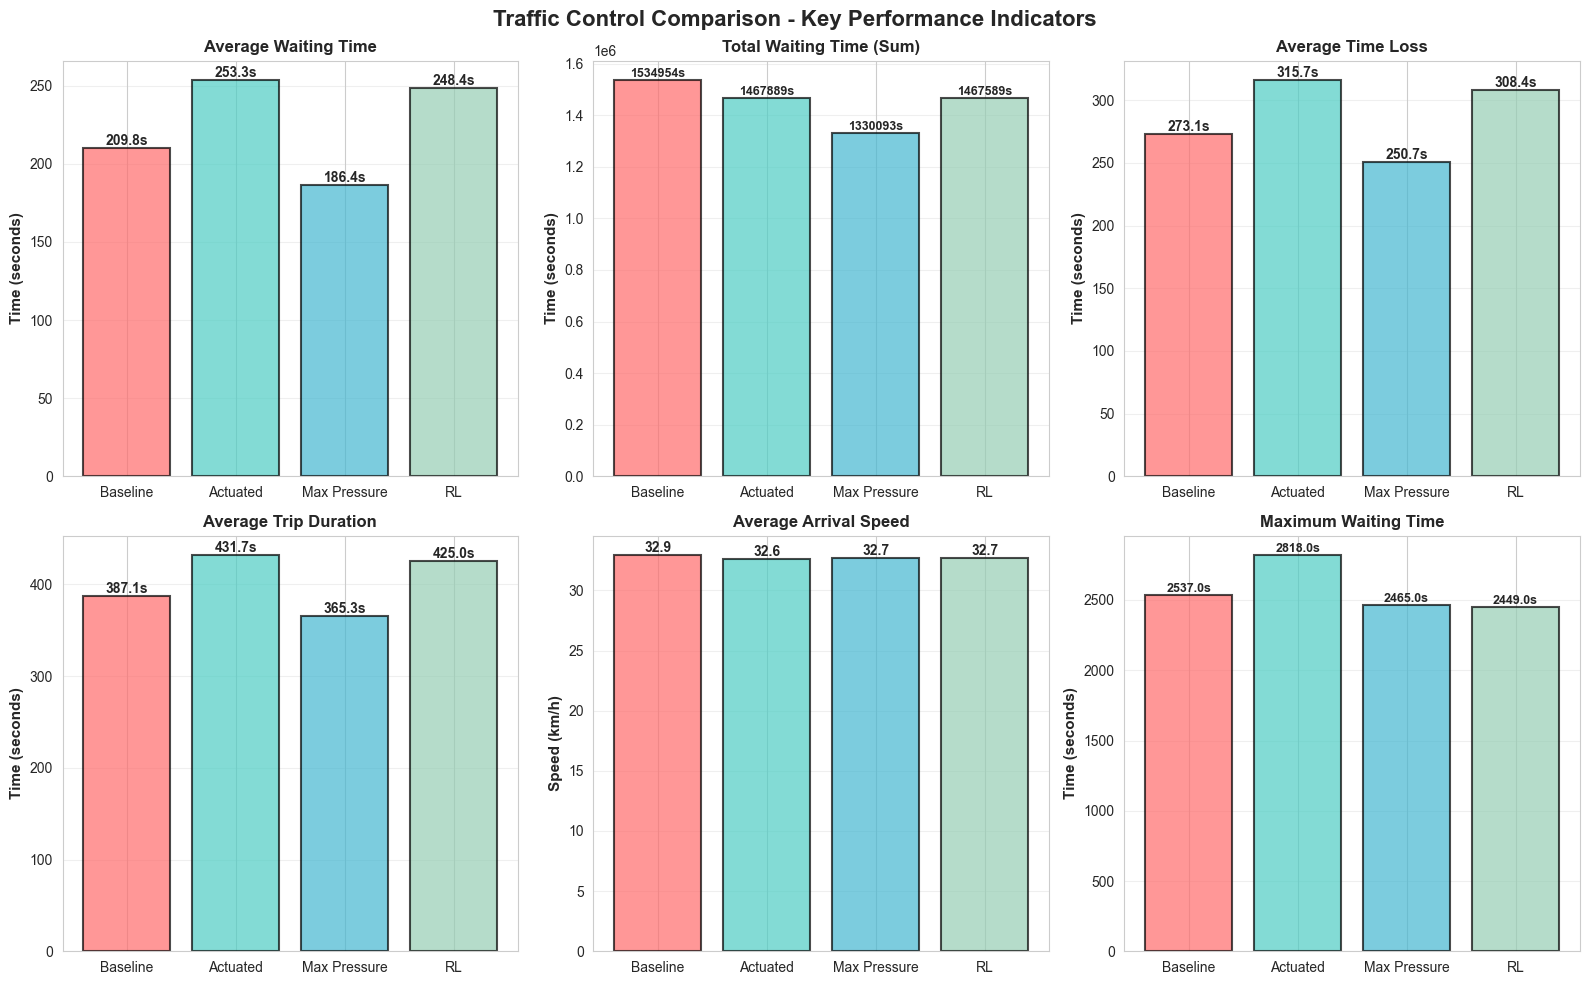

In [7]:
# Create KPI comparison plots
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Traffic Control Comparison - Key Performance Indicators', fontsize=16, fontweight='bold')

scenarios = summary_df.index
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

# 1. Average Waiting Time
ax = axes[0, 0]
waiting_times = summary_df['Avg Waiting Time (s)']
bars = ax.bar(scenarios, waiting_times, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Time (seconds)', fontsize=11, fontweight='bold')
ax.set_title('Average Waiting Time', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}s', ha='center', va='bottom', fontweight='bold')

# 2. Total Waiting Time
ax = axes[0, 1]
total_wait = summary_df['Total Waiting Time (s)']
bars = ax.bar(scenarios, total_wait, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Time (seconds)', fontsize=11, fontweight='bold')
ax.set_title('Total Waiting Time (Sum)', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.0f}s', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 3. Average Time Loss
ax = axes[0, 2]
time_loss = summary_df['Avg Time Loss (s)']
bars = ax.bar(scenarios, time_loss, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Time (seconds)', fontsize=11, fontweight='bold')
ax.set_title('Average Time Loss', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}s', ha='center', va='bottom', fontweight='bold')

# 4. Average Trip Duration
ax = axes[1, 0]
duration = summary_df['Avg Duration (s)']
bars = ax.bar(scenarios, duration, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Time (seconds)', fontsize=11, fontweight='bold')
ax.set_title('Average Trip Duration', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}s', ha='center', va='bottom', fontweight='bold')

# 5. Average Arrival Speed
ax = axes[1, 1]
speed_kmh = summary_df['Avg Arrival Speed (m/s)'] * 3.6  # Convert m/s to km/h
bars = ax.bar(scenarios, speed_kmh, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Speed (km/h)', fontsize=11, fontweight='bold')
ax.set_title('Average Arrival Speed', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}', ha='center', va='bottom', fontweight='bold')

# 6. Max Waiting Time
ax = axes[1, 2]
max_wait = summary_df['Max Waiting Time (s)']
bars = ax.bar(scenarios, max_wait, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Time (seconds)', fontsize=11, fontweight='bold')
ax.set_title('Maximum Waiting Time', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}s', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()

# Save figure
kpi_plot = os.path.join(OUTPUT_DIR, 'kpi_comparison.png')
plt.savefig(kpi_plot, dpi=300, bbox_inches='tight')
print(f"✓ KPI comparison plot saved to: {kpi_plot}")
plt.show()

## 5. Distribution Analysis - Waiting Time by Vehicle

C:\Users\antoi\AppData\Local\Temp\ipykernel_1940\192521072.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=scenario_order, patch_artist=True,


✓ Distribution plot saved to: c:\Users\antoi\OneDrive\Documents\Documents\Devoirs\Études sup\ENTPE 3A\Majeure transports\Mobility Control and Management\Project\Livrable 2\MOCOM_project_2\Scenario comparison results\waiting_time_distributions.png

WAITING TIME DISTRIBUTION STATISTICS

Baseline:
  Mean:        209.84 seconds
  Median:      115.00 seconds
  Std Dev:     266.75 seconds
  Min:           0.00 seconds
  Max:        2537.00 seconds
  Q1 (25%):     60.00 seconds
  Q3 (75%):    216.00 seconds

Actuated:
  Mean:        253.30 seconds
  Median:      144.00 seconds
  Std Dev:     296.44 seconds
  Min:           0.00 seconds
  Max:        2818.00 seconds
  Q1 (25%):     84.00 seconds
  Q3 (75%):    295.50 seconds

Max Pressure:
  Mean:        186.37 seconds
  Median:      118.00 seconds
  Std Dev:     223.21 seconds
  Min:           0.00 seconds
  Max:        2465.00 seconds
  Q1 (25%):     66.00 seconds
  Q3 (75%):    211.00 seconds

RL:
  Mean:        248.45 seconds
  Median:    

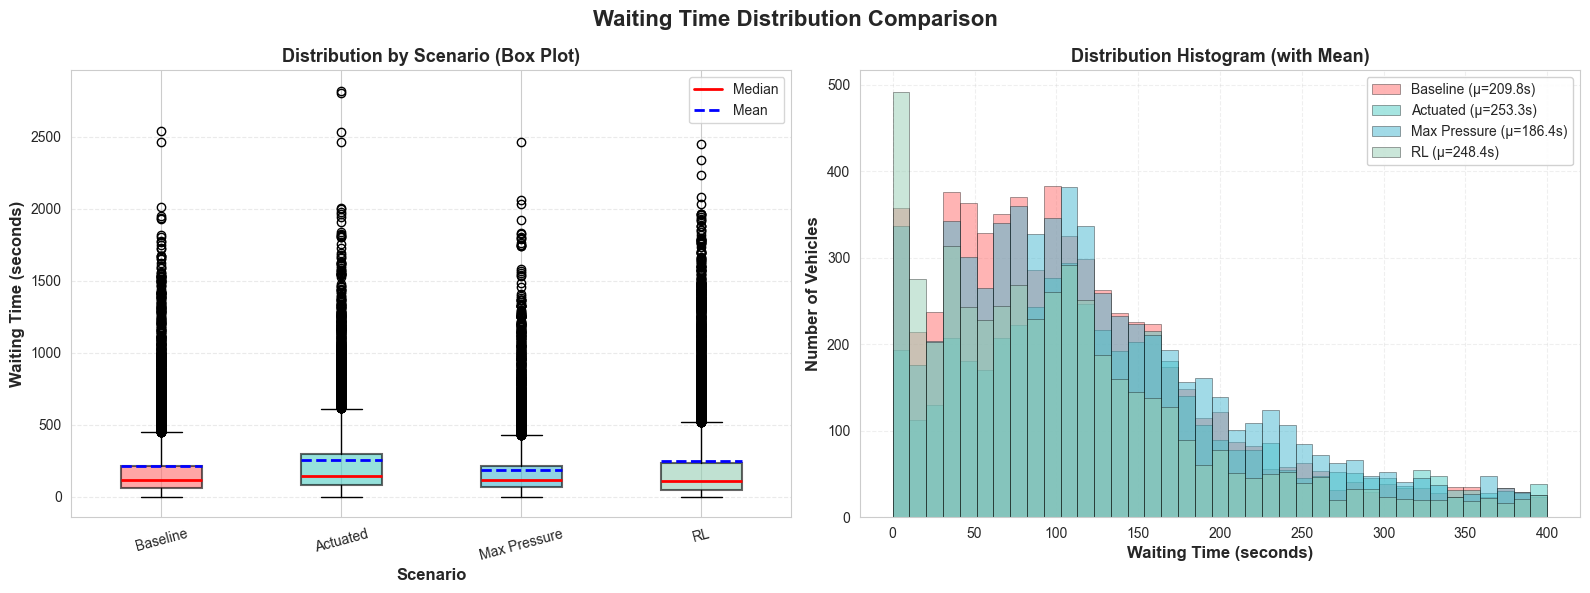

In [9]:
# Create distribution comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Waiting Time Distribution Comparison', fontsize=16, fontweight='bold')

# Define consistent colors and order
scenario_order = list(results_data.keys())
color_map = {
    'Baseline': '#FF6B6B',
    'Actuated': '#4ECDC4', 
    'Max Pressure': '#45B7D1',
    'RL': '#96CEB4'
}
colors_ordered = [color_map.get(s, '#999') for s in scenario_order]

# Box plot
ax = axes[0]
data_to_plot = [results_data[scenario]['df']['waitingTime'].values for scenario in scenario_order]
bp = ax.boxplot(data_to_plot, labels=scenario_order, patch_artist=True, 
                showmeans=True, meanline=True,
                medianprops=dict(color='red', linewidth=2),
                meanprops=dict(color='blue', linewidth=2, linestyle='--'))

# Color boxes
for patch, color in zip(bp['boxes'], colors_ordered):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
    patch.set_edgecolor('black')
    patch.set_linewidth(1.5)

ax.set_ylabel('Waiting Time (seconds)', fontsize=12, fontweight='bold')
ax.set_xlabel('Scenario', fontsize=12, fontweight='bold')
ax.set_title('Distribution by Scenario (Box Plot)', fontsize=13, fontweight='bold')
ax.grid(axis='y', alpha=0.4, linestyle='--')

# Add legend for box plot
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='red', linewidth=2, label='Median'),
    Line2D([0], [0], color='blue', linewidth=2, linestyle='--', label='Mean')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10)

# Rotate x-axis labels if needed
ax.tick_params(axis='x', rotation=15)

# Histogram with better bin strategy
ax = axes[1]

# Calculate optimal bin range across all scenarios
all_waiting_times = []
for scenario in scenario_order:
    all_waiting_times.extend(results_data[scenario]['df']['waitingTime'].values)
max_wait = max(all_waiting_times)
bins = np.linspace(0, min(max_wait, 400), 40)  # Cap at 400s for clarity

for scenario, color in zip(scenario_order, colors_ordered):
    data = results_data[scenario]['df']['waitingTime']
    median = data.median()
    mean = data.mean()
    
    # Plot histogram
    ax.hist(data, bins=bins, alpha=0.5, label=f'{scenario} (μ={mean:.1f}s)', 
            color=color, edgecolor='black', linewidth=0.5)

ax.set_xlabel('Waiting Time (seconds)', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Vehicles', fontsize=12, fontweight='bold')
ax.set_title('Distribution Histogram (with Mean)', fontsize=13, fontweight='bold')
ax.legend(loc='upper right', fontsize=10, framealpha=0.9)
ax.grid(axis='both', alpha=0.3, linestyle='--')

plt.tight_layout()

# Save figure
dist_plot = os.path.join(OUTPUT_DIR, 'waiting_time_distributions.png')
plt.savefig(dist_plot, dpi=300, bbox_inches='tight')
print(f"✓ Distribution plot saved to: {dist_plot}")

# Print summary statistics
print("\n" + "="*80)
print("WAITING TIME DISTRIBUTION STATISTICS")
print("="*80)
for scenario in scenario_order:
    data = results_data[scenario]['df']['waitingTime']
    print(f"\n{scenario}:")
    print(f"  Mean:      {data.mean():8.2f} seconds")
    print(f"  Median:    {data.median():8.2f} seconds")
    print(f"  Std Dev:   {data.std():8.2f} seconds")
    print(f"  Min:       {data.min():8.2f} seconds")
    print(f"  Max:       {data.max():8.2f} seconds")
    print(f"  Q1 (25%):  {data.quantile(0.25):8.2f} seconds")
    print(f"  Q3 (75%):  {data.quantile(0.75):8.2f} seconds")
print("="*80)

plt.show()

## 6. Performance Improvements vs Baseline


IMPROVEMENT vs BASELINE
              Waiting Time Improvement (%)  Duration Improvement (%)  Avg Speed (m/s)
Scenario                                                                             
Actuated                            -20.71                    -11.52             9.05
Max Pressure                         11.19                      5.64             9.09
RL                                  -18.40                     -9.80             9.08

✓ Improvements saved to: c:\Users\antoi\OneDrive\Documents\Documents\Devoirs\Études sup\ENTPE 3A\Majeure transports\Mobility Control and Management\Project\Livrable 2\MOCOM_project_2\Scenario comparison results\improvements_vs_baseline.csv
✓ Improvement plot saved to: c:\Users\antoi\OneDrive\Documents\Documents\Devoirs\Études sup\ENTPE 3A\Majeure transports\Mobility Control and Management\Project\Livrable 2\MOCOM_project_2\Scenario comparison results\improvements_vs_baseline.png


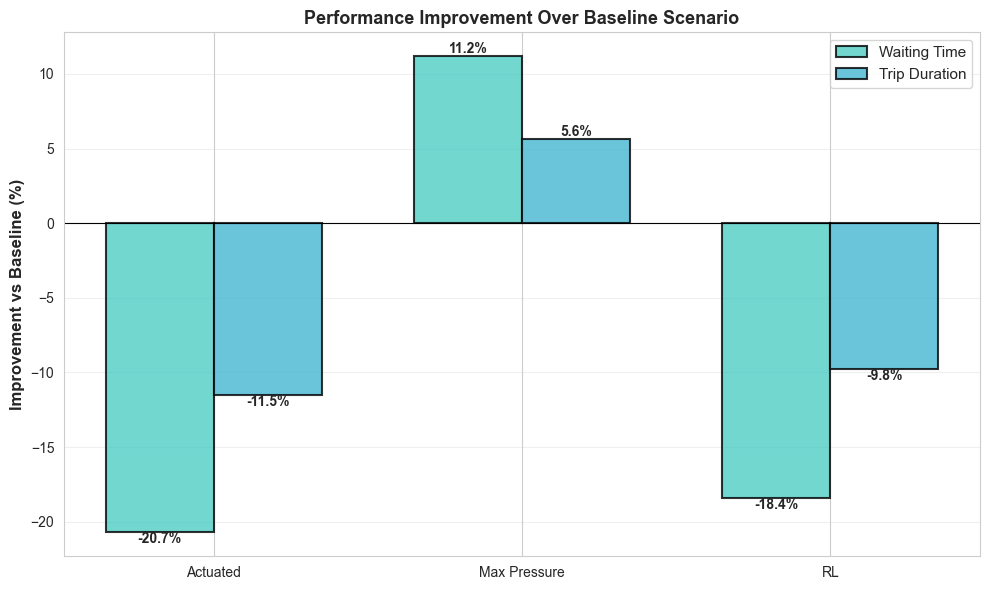

In [10]:
# Calculate improvements vs baseline
baseline_avg_wait = summary_df.loc['Baseline', 'Avg Waiting Time (s)']
baseline_duration = summary_df.loc['Baseline', 'Avg Duration (s)']

improvements = []
for scenario in summary_df.index:
    if scenario != 'Baseline':
        avg_wait = summary_df.loc[scenario, 'Avg Waiting Time (s)']
        duration = summary_df.loc[scenario, 'Avg Duration (s)']
        speed = summary_df.loc[scenario, 'Avg Arrival Speed (m/s)']
        
        wait_improvement = ((baseline_avg_wait - avg_wait) / baseline_avg_wait) * 100
        duration_improvement = ((baseline_duration - duration) / baseline_duration) * 100
        
        improvements.append({
            'Scenario': scenario,
            'Waiting Time Improvement (%)': wait_improvement,
            'Duration Improvement (%)': duration_improvement,
            'Avg Speed (m/s)': speed,
        })

improvement_df = pd.DataFrame(improvements).set_index('Scenario')

# Save improvements to CSV
improvement_csv = os.path.join(OUTPUT_DIR, 'improvements_vs_baseline.csv')
improvement_df.to_csv(improvement_csv)

print("\n" + "="*80)
print("IMPROVEMENT vs BASELINE")
print("="*80)
print(improvement_df.round(2).to_string())
print("="*80)
print(f"\n✓ Improvements saved to: {improvement_csv}")

# Visualization of improvements
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(improvement_df.index))
width = 0.35

bars1 = ax.bar(x - width/2, improvement_df['Waiting Time Improvement (%)'], 
               width, label='Waiting Time', color='#4ECDC4', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, improvement_df['Duration Improvement (%)'], 
               width, label='Trip Duration', color='#45B7D1', alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_ylabel('Improvement vs Baseline (%)', fontsize=12, fontweight='bold')
ax.set_title('Performance Improvement Over Baseline Scenario', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(improvement_df.index)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom' if height > 0 else 'top', fontweight='bold')

plt.tight_layout()

# Save figure
improvement_plot = os.path.join(OUTPUT_DIR, 'improvements_vs_baseline.png')
plt.savefig(improvement_plot, dpi=300, bbox_inches='tight')
print(f"✓ Improvement plot saved to: {improvement_plot}")
plt.show()

## 7. Scenario Rankings

In [11]:
# Create rankings
rankings_output = []
rankings_output.append("\n" + "="*80)
rankings_output.append("SCENARIO RANKINGS")
rankings_output.append("="*80)

# Waiting time ranking (lower is better)
rankings_output.append("\n1. AVERAGE WAITING TIME (Lower is Better)")
rankings_output.append("-" * 80)
for i, (scenario, wait_time) in enumerate(summary_df['Avg Waiting Time (s)'].sort_values().items(), 1):
    rankings_output.append(f"   {i}. {scenario:20s} {wait_time:8.2f} seconds")

# Time loss ranking (lower is better)
rankings_output.append("\n2. AVERAGE TIME LOSS (Lower is Better)")
rankings_output.append("-" * 80)
for i, (scenario, time_loss) in enumerate(summary_df['Avg Time Loss (s)'].sort_values().items(), 1):
    rankings_output.append(f"   {i}. {scenario:20s} {time_loss:8.2f} seconds")

# Trip duration ranking (lower is better)
rankings_output.append("\n3. AVERAGE TRIP DURATION (Lower is Better)")
rankings_output.append("-" * 80)
for i, (scenario, duration) in enumerate(summary_df['Avg Duration (s)'].sort_values().items(), 1):
    rankings_output.append(f"   {i}. {scenario:20s} {duration:8.2f} seconds")

# Speed ranking (higher is better)
rankings_output.append("\n4. AVERAGE ARRIVAL SPEED (Higher is Better)")
rankings_output.append("-" * 80)
for i, (scenario, speed) in enumerate(summary_df['Avg Arrival Speed (m/s)'].sort_values(ascending=False).items(), 1):
    rankings_output.append(f"   {i}. {scenario:20s} {speed:8.2f} m/s")

rankings_output.append("=" * 80)

# Print rankings
for line in rankings_output:
    print(line)

# Save rankings to text file
rankings_file = os.path.join(OUTPUT_DIR, 'scenario_rankings.txt')
with open(rankings_file, 'w') as f:
    f.write('\n'.join(rankings_output))
print(f"\n✓ Rankings saved to: {rankings_file}")


SCENARIO RANKINGS

1. AVERAGE WAITING TIME (Lower is Better)
--------------------------------------------------------------------------------
   1. Max Pressure           186.37 seconds
   2. Baseline               209.84 seconds
   3. RL                     248.45 seconds
   4. Actuated               253.30 seconds

2. AVERAGE TIME LOSS (Lower is Better)
--------------------------------------------------------------------------------
   1. Max Pressure           250.65 seconds
   2. Baseline               273.08 seconds
   3. RL                     308.41 seconds
   4. Actuated               315.74 seconds

3. AVERAGE TRIP DURATION (Lower is Better)
--------------------------------------------------------------------------------
   1. Max Pressure           365.27 seconds
   2. Baseline               387.10 seconds
   3. RL                     425.02 seconds
   4. Actuated               431.71 seconds

4. AVERAGE ARRIVAL SPEED (Higher is Better)
--------------------------------------